# Knight's Tour: Data Augmentation Notebook

In [1]:
import random
import polars as pl
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# from plotting_preferences_AS import plotting_preferences_AS

In [2]:
# plotting_preferences_AS()
random.seed(821378259)

### Loading the dataset and re-saving a sorted version for better compression

In [21]:
### REPLACE PATH WITH YOUR GENERATED SOLUTIONS
path_to_file = "../data/final/tours_8x8_100000000_20241127_combined.parquet"
full_df = pl.read_parquet(path_to_file)

In [22]:
print(
    len(full_df),
    len(full_df.unique())
)

22386084 22386084


In [23]:
full_df = full_df.cast(pl.Int8)

In [25]:
full_df.head()

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
24,9,3,13,7,22,39,54,60,50,56,41,58,48,33,16,1,18,8,2,12,6,23,29,14,31,46,63,53,47,62,52,37,43,28,11,5,20,35,25,40,57,42,59,49,32,26,36,21,38,44,27,17,0,10,4,19,34,51,61,55,45,30,15
18,1,16,33,48,58,52,62,47,30,15,5,11,17,0,10,4,14,31,21,6,23,13,7,22,39,54,37,20,3,9,24,41,56,50,60,45,35,29,46,63,53,59,49,43,26,32,42,36,51,57,40,34,19,25,8,2,12,27,44,61,55,38,28
48,58,41,56,50,40,57,51,61,55,38,23,6,12,2,8,25,35,52,62,47,53,63,46,31,14,4,21,15,5,22,7,13,30,45,60,54,39,29,44,59,42,36,19,9,24,34,49,32,17,0,10,27,37,20,3,18,1,11,28,43,33,16,26
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,44,59,49,43,58,48,42,27,21,31,14,29,35,20,37,52,46,63,53,36,19,4,10,0,17,32,26,16,33
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,44,27,42,52,37,43,58,48,33,16,26,32,49,59,53,63,46,36,21,31,14,20,35,29,19,4,10,0,17


In [27]:
# sorting and saving the dataframe to reduce the compressed file size
# size was reduced by ~50%, neat

full_df = full_df.sort(by="move_0")
full_df.write_parquet(
    "../data/final/tours_8x8_22386084_20241203_all.parquet",
    compression="zstd"
)

In [2]:
full_df = pl.read_parquet("../data/final/tours_8x8_22386084_20241203_all.parquet")
full_df

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,17,2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,49,43,58,48,33,16,26,32,42,52,37,27,10,4,21,36,19,29,44,59,53,63,46,31,14,20,35
0,17,2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,19,4,14,20,37,43,33,48,58,52,35,29,44,27,10,16,26,32,49,59,42,36,53,63,46,31,21
0,17,2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,49,32,42,48,58,52,35,29,44,59,53,63,46,36,19,4,10,20,14,31,37,43,26,16,33,27,21
0,17,2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,19,36,53,63,46,52,35,29,14,20,37,31,21,4,10,16,33,48,58,43,26,32,49,59,42,27,44
0,17,2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,19,29,46,63,53,59,49,32,26,16,10,20,35,52,58,43,33,48,42,36,21,4,14,31,37,27,44
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
54,39,22,7,13,3,9,24,41,56,50,60,45,62,47,30,15,5,11,1,16,33,48,58,52,37,31,14,4,21,6,23,38,55,61,51,57,40,25,8,2,12,18,28,43,49,59,53,63,46,36,19,29,35,20,26,32,42,27,10,0,17,34,44
54,60,50,56,41,58,48,33,16,1,11,5,15,30,47,62,52,35,45,39,22,7,13,23,6,12,2,8,18,24,9,3,20,26,32,49,59,42,57,40,25,10,0,17,27,37,43,28,34,51,61,55,38,44,29,14,31,21,4,19,36,53,63,46
54,60,50,56,41,58,48,33,16,1,11,5,15,30,47,62,52,37,31,14,4,10,0,17,2,8,25,40,57,51,61,55,45,39,22,7,13,23,6,21,27,12,18,35,20,3,9,24,34,28,38,44,29,19,36,46,63,53,43,26,32,49,59,42


## Finding the number of truly unique tours

The generated dataset was created using two functions
- **Method 1**: One which used the Warnsdorff heuristic with early termination to find tours (~6 million tours)
- **Method 2**: One which used Backtracking with a degree heuristic to find tours (~16 million tours)

Tours generated using *Method 1* likely has symmetric/reflected tours (i.e., two tours that begin from different positions, but if rotated or flipped, are identical to each other) because during generation, the starting positions were selected randomly instead of being constrained to one of the quadrants of an 8 x 8 chessboard. 

So first, I will find the number of truly unique tours, and then, I will augment those tours by finding all their rotations and reflections tours effectively increasing the dataset size by a factor of 8.

In [111]:
def generate_symmetric_tours(tour):
    """
    This function generates all eight symmetric tours — four rotations 
    and four relfections — from the given knight's tour.

    Portions of this code were iteratively corrected using GPT-4o.
    Prompt: "For the given function {copy-paste function}, could you correct why 
    the tours aren't being reflected properly?"
    
    """
    # Convert the tour into a 2D representation (row, col) indices
    tour_coords = [(pos // 8, pos % 8) for pos in tour]

    def to_linear(pos):
        return pos[0] * 8 + pos[1]

    def rotate_90(coords):
        return [(col, 7 - row) for row, col in coords]

    def reflect_horizontal(coords):
        return [(row, 7 - col) for row, col in coords]

    def reflect_vertical(coords):
        return [(7 - row, col) for row, col in coords]

    def reflect_diagonal(coords):
        return [(col, row) for row, col in coords]

    def reflect_anti_diagonal(coords):
        return [(7 - col, 7 - row) for row, col in coords]

    # generating all transformations
    transformations = []
    current_coords = tour_coords
    for _ in range(4):  
        transformations.append(current_coords)
        current_coords = rotate_90(current_coords)
    
    # adding reflections of the original tour
    transformations += [
        reflect_horizontal(tour_coords),
        reflect_vertical(tour_coords),
        reflect_diagonal(tour_coords),
        reflect_anti_diagonal(tour_coords),
    ]

    # converting 2D indices to 1D indices
    symmetric_tours = [list(map(to_linear, coords)) for coords in transformations]
    return symmetric_tours


def find_unique_tours(all_tours):
    """
    This function takes as an input a sequence of sequences and returns only the unique knight's tours.
    """
    # defining acceptable starting positions
    first_quadrant_indices = set(i.item() for i in np.array(range(64)).reshape(8, 8)[:4, :4].flatten())
    unique_tours = set()
    
    for tour in tqdm(all_tours):
        # generating all symmetries
        symmetric_tours = generate_symmetric_tours(tour)
        
        # only choosing tours that start from the first quadrant of the board
        valid_tours = [t for t in symmetric_tours if t[0] in first_quadrant_indices]
        
        if valid_tours:
            chosen_tour = min(valid_tours)
            unique_tours.add(tuple(chosen_tour))
    
    return unique_tours

In [4]:
unique_tours = find_unique_tours(full_df.rows())

100%|███████████████████████████████████████████| 22386084/22386084 [15:54<00:00, 23449.71it/s]


In [5]:
# deleting the stored dataframe to free up memory

del full_df

In [6]:
import pickle

with open('../data/final/unique_tours_set.pkl', 'wb') as f:
    pickle.dump(unique_tours, f)
    
#with open('../data/final/unique_tours_set.pkl', 'rb') as f:
#    unique_tours = pickle.load(f)

In [7]:
unique_tours_tuple = tuple(unique_tours)

In [8]:
del unique_tours

In [9]:
(num_unique_tours := len(unique_tours_tuple))

17022661

In [10]:
(num_augmented_tours := 8 * num_unique_tours)

136181288

In [11]:
unique_tours_dict = {
    f"move_{i}": [unique_tours_tuple[j][i] for j in range(len(unique_tours_tuple))] for i in range(len(unique_tours_tuple[0]))
}

In [12]:
del unique_tours_tuple

In [13]:
unique_tours_df = pl.DataFrame(
    unique_tours_dict,
    schema={f"move_{i}": pl.Int8 for i in range(64)},
).sort(by="move_0")

In [14]:
# saving all the unique tours
unique_tours_df.write_parquet(
    f"../data/final/tours_8x8_17022661_20241204_unique.parquet",
    compression="zstd"
)

In [104]:
# loading the unique tours as a df
unique_tours_df = pl.read_parquet(
    f"../data/final/tours_8x8_17022661_20241204_unique.parquet",
)

In [105]:
unique_tours_df

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,14,4,19,2,17,27,42,36,21,6,12,29,23,38,28,34,49,32,26,43,37,31,46,63,53,59,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,43,28,38,23,6,21,4,19,36,26,32,42,27,12,2,17,34,49,59,53,63,46,31,14,29,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,27,42,59,44,34,49,32,17,2,12,6,23,38,28,43,26,36,53,63,46,31,21,4,19,29,14
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,29,46,63,53,59,49,43,28,38,23,6,12,2,19,34,44,27,17,32,26,20,37,31,14,4,21,36,42
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,29,23,6,12,27,37,20,14,31,46,63,53,59,44,38,28,34,49,43,26,32,17,2,19,4,21,36,42
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
27,12,6,23,38,55,61,44,54,60,50,56,41,24,9,3,13,7,22,39,29,14,4,19,2,8,25,40,57,51,34,17,0,10,16,1,18,33,48,58,43,49,32,26,11,28,45,35,20,5,15,30,47,62,52,37,31,21,36,42,59,53,63,46
27,12,6,23,13,7,22,39,54,60,50,56,41,58,48,33,16,1,18,3,9,24,34,40,57,51,61,55,38,44,59,49,32,26,43,37,31,46,63,53,47,30,15,5,20,14,29,19,2,8,25,35,45,28,11,17,0,10,4,21,36,42,52,62
27,12,6,23,13,7,22,39,54,60,50,56,41,58,48,33,16,1,18,3,9,24,34,40,57,51,61,55,38,44,59,49,32,42,52,35,29,14,31,46,63,53,47,62,45,28,43,37,20,30,15,5,11,26,36,21,4,10,0,17,2,19,25,8


In [22]:
np.array(range(64)).reshape(8, 8)

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [16]:
unique_tours_df.filter(~pl.col("move_0").is_in([8, 17, 26]))

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,14,4,19,2,17,27,42,36,21,6,12,29,23,38,28,34,49,32,26,43,37,31,46,63,53,59,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,43,28,38,23,6,21,4,19,36,26,32,42,27,12,2,17,34,49,59,53,63,46,31,14,29,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,27,42,59,44,34,49,32,17,2,12,6,23,38,28,43,26,36,53,63,46,31,21,4,19,29,14
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,29,46,63,53,59,49,43,28,38,23,6,12,2,19,34,44,27,17,32,26,20,37,31,14,4,21,36,42
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,29,23,6,12,27,37,20,14,31,46,63,53,59,44,38,28,34,49,43,26,32,17,2,19,4,21,36,42
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
27,12,6,23,38,55,61,44,54,60,50,56,41,24,9,3,13,7,22,39,29,14,4,19,2,8,25,40,57,51,34,17,0,10,16,1,18,33,48,58,43,49,32,26,11,28,45,35,20,5,15,30,47,62,52,37,31,21,36,42,59,53,63,46
27,12,6,23,13,7,22,39,54,60,50,56,41,58,48,33,16,1,18,3,9,24,34,40,57,51,61,55,38,44,59,49,32,26,43,37,31,46,63,53,47,30,15,5,20,14,29,19,2,8,25,35,45,28,11,17,0,10,4,21,36,42,52,62
27,12,6,23,13,7,22,39,54,60,50,56,41,58,48,33,16,1,18,3,9,24,34,40,57,51,61,55,38,44,59,49,32,42,52,35,29,14,31,46,63,53,47,62,45,28,43,37,20,30,15,5,11,26,36,21,4,10,0,17,2,19,25,8


In [18]:
unique_tours_df["move_0"].unique().to_list()

[0, 1, 2, 3, 9, 10, 11, 18, 19, 27]

In [21]:
set(i.item() for i in np.array(range(64)).reshape(8, 8)[:4, :4].flatten())

{0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27}

In [20]:
np.array(range(64)).reshape(8, 8)[:4, :4]

array([[ 0,  1,  2,  3],
       [ 8,  9, 10, 11],
       [16, 17, 18, 19],
       [24, 25, 26, 27]])

The first indices look correct! 8, 16, 17, 24, 25, and 26 are reflections of the indices present, so they aren't present but can be recreated using the `generate_symmetric_tours` function above.

## Dataset Augmentation

In [53]:
np.array(generate_symmetric_tours(unique_tours_df.row(10687687)))[:, :10]

array([[11,  1, 16, 33, 48, 58, 52, 62, 47, 53],
       [30, 15,  5, 11,  1, 16, 33, 48, 58, 41],
       [52, 62, 47, 30, 15,  5, 11,  1, 16, 10],
       [33, 48, 58, 52, 62, 47, 30, 15,  5, 22],
       [12,  6, 23, 38, 55, 61, 51, 57, 40, 50],
       [51, 57, 40, 25,  8,  2, 12,  6, 23, 13],
       [25,  8,  2, 12,  6, 23, 38, 55, 61, 46],
       [38, 55, 61, 51, 57, 40, 25,  8,  2, 17]])

In [66]:
# I have a hunch about move uniqueness, so checking that

uniqueness_lengths = [len(unique_tours_df[:, :col].unique()) for col in range(len(unique_tours_df.row(0)))]

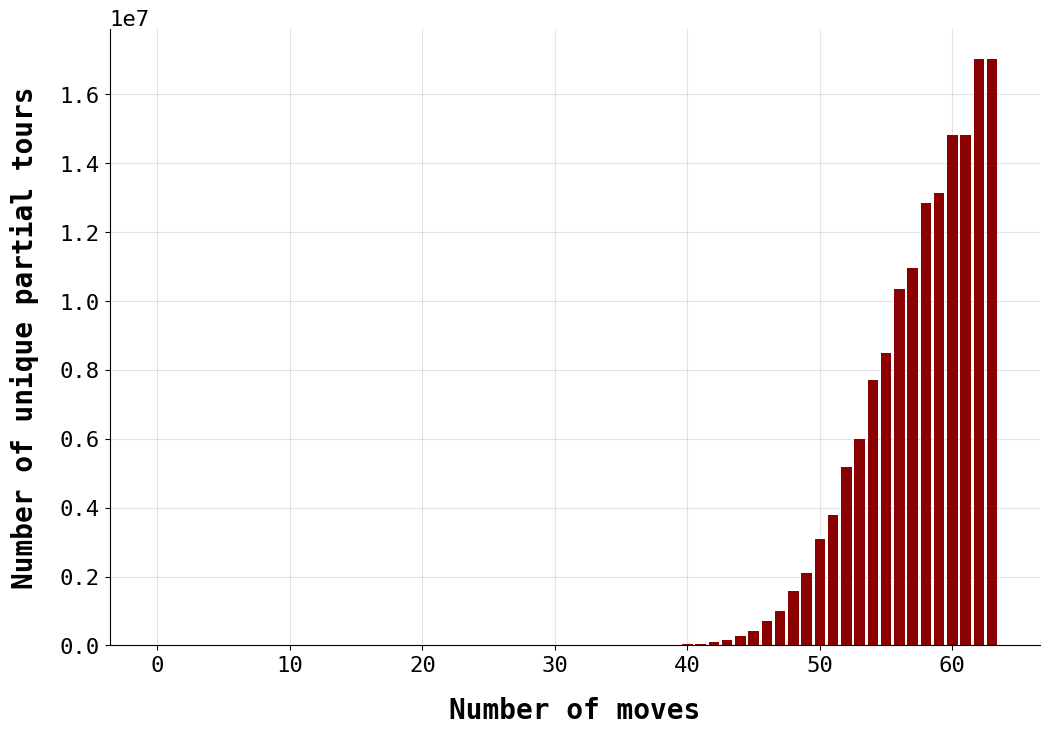

In [134]:
fig, ax= plt.subplots()

plt.bar(
    range(len(unique_tours_df.row(0))), uniqueness_lengths, color="darkred"
)

plt.xlabel("Number of moves", fontweight='bold', labelpad = 15, fontsize = 20)
plt.ylabel("Number of unique partial tours", fontweight='bold', labelpad = 15, fontsize = 20)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.35)

plt.show()

**This is interesting.**
- Uptill the ~45th step, the vast majority of moves are identical.
- This is partially because of the backtracking algorithm that was used to generate most of the tours.
- My naive guess is that this may make the model memorize more than generalize.
- To prevent memorization:
    - I will remove tours from ~3 starting positions, and these will be used for testing the model's performance.
    - Symmetric tours from all the other positions will be present in the augmented dataset, increasing uniqueness of partial tours.


In [113]:
length_tours_each_pos = [len(unique_tours_df.filter(pl.col("move_0") == first_move)) for first_move in unique_tours_df["move_0"].unique()]
pos_tour_lengths_dict = {f"{i}":j for i, j in zip(unique_tours_df["move_0"].unique(), length_tours_each_pos)}
pos_tour_lengths_dict = dict(sorted(pos_tour_lengths_dict.items(), key=lambda item: item[1], reverse=True))

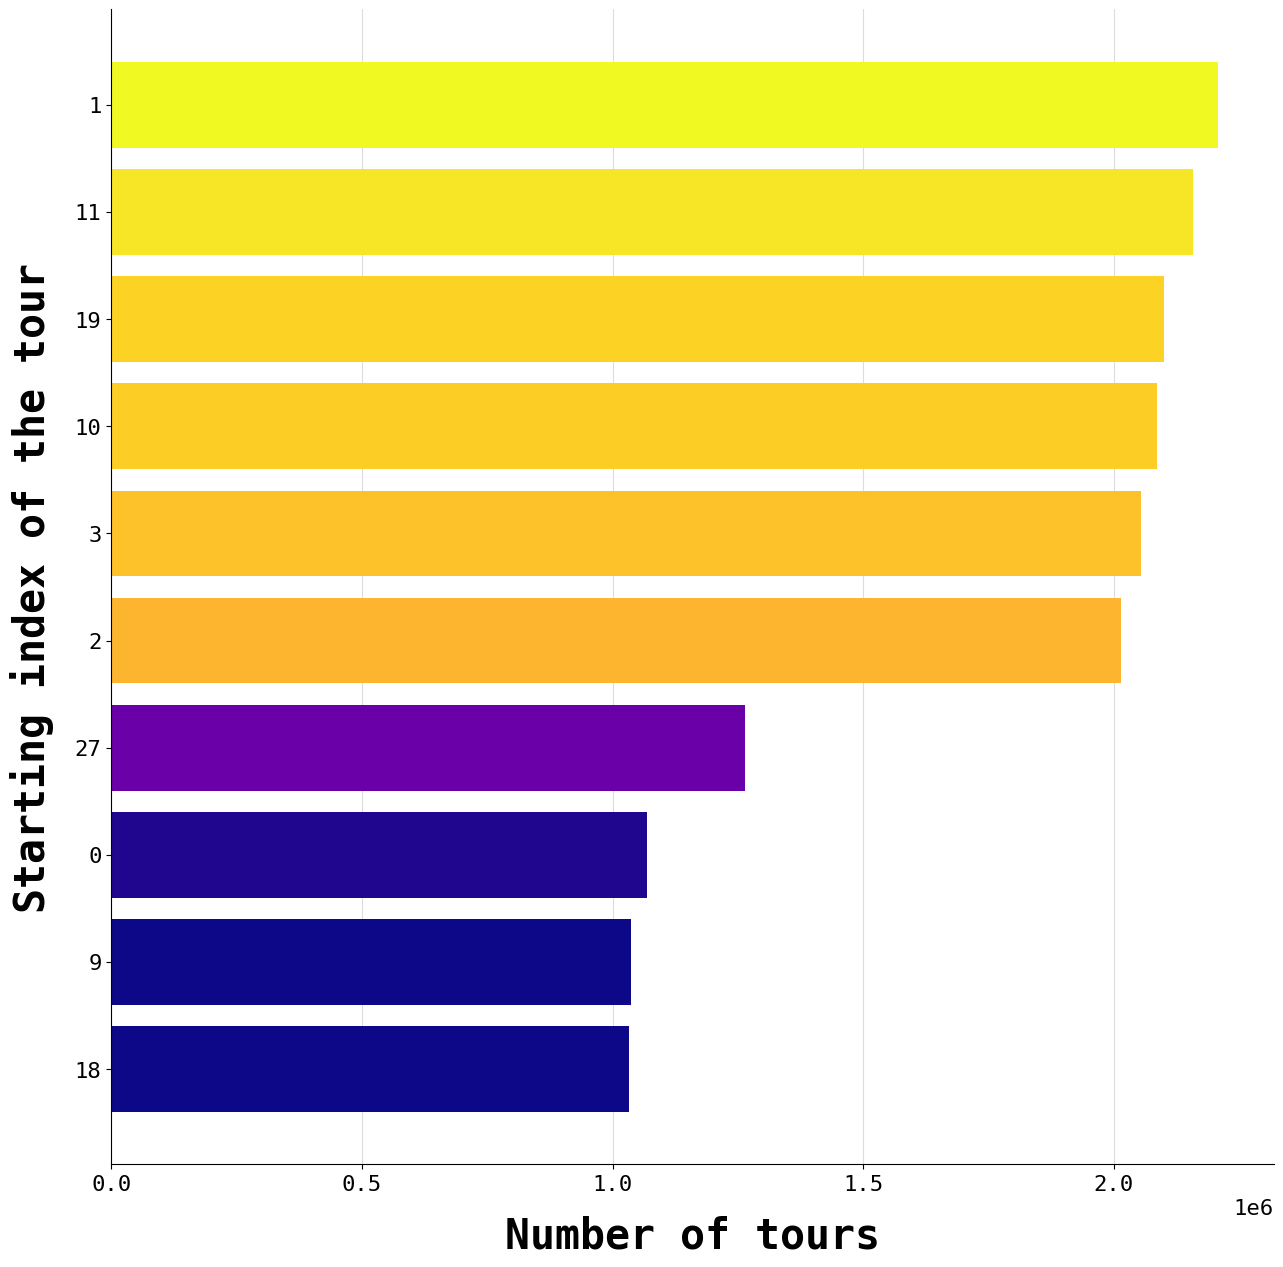

In [136]:
bars = list(pos_tour_lengths_dict.keys())
height = list(pos_tour_lengths_dict.values())

my_cmap = plt.get_cmap("plasma")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# Bar plot
fig_bar, ax_bar = plt.subplots(figsize = (15, 15))

ax_bar.barh(bars, height, color = my_cmap(rescale(height)))
ax_bar.tick_params(axis='y', which='minor', color = 'black')
ax_bar.set_xlabel('Number of tours', fontweight='bold', labelpad = 15, fontsize = 30)
ax_bar.set_ylabel("Starting index of the tour", fontweight = 'bold', fontsize = 30, labelpad = 15)

ax_bar.set_axisbelow(True)
plt.grid(color = "gainsboro", axis = "x")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.invert_yaxis() 

plt.show()

In [137]:
np.array(range(64)).reshape(8, 8)

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [150]:
# segmenting the unique tours dataset, removing tours from three positions

8 * len(unique_tours_df.filter(~pl.col("move_0").is_in([9]))) - 8 * 0.5 * len(unique_tours_df.filter(pl.col("move_0").is_in([11, 2])))

111202068.0

In [147]:
8 * 0.5 * len(unique_tours_df.filter(pl.col("move_0").is_in([2])))

8053708.0

## Updated augmentation plan 
1. **Removing tours from one beginning position entirely.** The model will not see any tours from this position.
2. **Removing ~50% of unique tours from another starting positions.** The model will see some solutions from these positions but not all of them, and the ones not in the training set could be used for validation.
3. **Removing ~50% of symmetric tours from yet another starting positions.** The model will _effectively_ see every single unique solution from this position.

The intuition behind these three segments are to gauge the level of interpolation/extrapolation and generalization, and each of them pose a varying level of difficulty.
- After the model finishes training, if the model is able to solve a tour from the completely excluded position (point 1), it would be a strong indication that the model generalizes and learns and doesn't just memorize as there wouldn't be any solutions from this position in the training set. I expect this model to ace unseen data from points 2 and 3 as well.
- If the model is able to solve the point 2 (but not point 1), then the model is showing some level of generalization. This would still be a fairly strong kind of generalization because it is solving tours This model, I expect, will ace the cases from point 3 as well.
- If the model is only able to solve unseen tours from point 3, then it would be an evidence of a weak kind of generalization. The model is at least able to identify symmetric tours and complete them from unseen starting positions (or unseen partial tours), but it doesn't truly learn the rules of the game and isn't able to solve tours from completely omitted starting points.
- Two other possibilities:
  - The model is able to solve tours half the time or so, indicative of weak memorization
  - The model doesn't learn the tour dynamics at all and doesn't learn anything
- **For point 1, I am choosing the 9th index, i.e., position (1, 1). For point 2, I am choosing the 11th index, i.e., position (1, 3). For point 3, I am going with the 2nd index, i.e., position (0, 2).** All these three positions are unique. One is on the diagnol and the other two do not share the same row or column.

In [236]:
point_2_3_reduction = 0.5

not_training_num = int(
    8 *
    (
        len(unique_tours_df.filter(~pl.col("move_0").is_in([9]))) 
        - point_2_3_reduction * len(unique_tours_df.filter(pl.col("move_0").is_in([11, 2])))
    )
)

training_num = int(0.93 * not_training_num)
validation_num = int(0.07 * not_training_num)
testing_num = 8 * len(unique_tours_df) - training_num - validation_num

point1_size = 8 * len(unique_tours_df.filter(pl.col("move_0").is_in([9])))
point2_size = int(8 * point_2_3_reduction * len(unique_tours_df.filter(pl.col("move_0").is_in([11]))))
point3_size = int(8 * point_2_3_reduction * len(unique_tours_df.filter(pl.col("move_0").is_in([2]))))

print(f"         Tours in the training set ~ {training_num:,}")
print(f"       Tours in the validation set ~ {validation_num:,}")
print(f"  Tours in the testing set (total) ~ {testing_num:,}")
print(f"Tours in the testing set (Point 1) ~ {point1_size:,}")
print(f"Tours in the testing set (Point 2) ~ {point2_size:,}")
print(f"Tours in the testing set (Point 3) ~ {point3_size:,}")

print(np.isclose(testing_num, (point1_size + point2_size + point3_size)))

         Tours in the training set ~ 103,417,923
       Tours in the validation set ~ 7,784,144
  Tours in the testing set (total) ~ 24,979,221
Tours in the testing set (Point 1) ~ 8,294,456
Tours in the testing set (Point 2) ~ 8,631,056
Tours in the testing set (Point 3) ~ 8,053,708
True


#### Generating and saving all symmetric tours

In [ ]:
enormous_dictionary = {
    
}
generate_symmetric_tours(unique_tours_df.row(i))

In [466]:
not_training_df = unique_tours_df.filter(~pl.col("move_0").is_in([9]))

In [469]:
# excluding all tours beginning from position 9 (1, 3)
testing_df_1 = unique_tours_df.filter(pl.col("move_0").is_in([9]))
testing_df_1.write_parquet(
    f"../data/final/test_point1_pos9_tours_8x8_{len(testing_df_1)}.parquet",
    compression="zstd"
)

print(8 * len(testing_df_1))

8294456


In [501]:
# excluding half of the unique tours beginning from position 11 (1, 1)
all_df_2 = unique_tours_df.filter(pl.col("move_0").is_in([11]))
testing_df_2 = all_df_2.sample(fraction=0.5, seed=821378259)
testing_df_2.write_parquet(
    f"../data/final/test_point2_pos11_tours_8x8_{len(testing_df_2)}.parquet",
    compression="zstd"
)

print(8 * len(testing_df_2))

8631056


In [502]:
testing_df_2

training_df_2 = all_df_2.join(
    testing_df_2,
    on=all_df_2.columns,  
    how="anti"
)

print(8 * len(training_df_2))

8631056


In [503]:
# double checking that the testing and training portions of pos 11 dataset are distinct
training_df_2.join(
    testing_df_2,
    on=training_df_2.columns, 
    how="inner" 
)

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8


In [504]:
# saving the training portion
training_df_2.write_parquet(
    f"../data/final/train_point2_pos11_tours_8x8_{len(training_df_2)}.parquet",
    compression="zstd"
)

In [8]:
def generate_symmetric_tours_vectorized(tours):
    """
    This function generates all eight symmetric tours — four rotations 
    and four relfections — from the given knight's tour in a vectorized fashion.

    This code was iteratively generated using GPT-4o.
    Prompt: "Could you vectorize this function {copy-paste generate_symmetric_tours}
    such that it can generate symmetric tours in a column-wise fashion? I have a large
    parquet table with 64 columns titled move_i and each entry contains a integer ranging 
    from 0-63 which indicates a position on the chessboard that can be drawn as follows:
    np.array(range(64)).reshape(8, 8)?"
    
    """
    T, L = tours.shape  # Number of tours and tour length

    # converting 
    rows = tours // 8
    cols = tours % 8

    # intializing empty arrays
    n_transformations = 8
    transformed_rows = np.zeros((T, n_transformations, L), dtype=int)
    transformed_cols = np.zeros((T, n_transformations, L), dtype=int)

    # transformation functions
    def rotate_90(r, c):
        return c, 7 - r

    def rotate_180(r, c):
        return 7 - r, 7 - c

    def rotate_270(r, c):
        return 7 - c, r

    def reflect_horizontal(r, c):
        return r, 7 - c

    def reflect_vertical(r, c):
        return 7 - r, c

    def reflect_diagonal(r, c):
        return c, r

    def reflect_anti_diagonal(r, c):
        return 7 - c, 7 - r

    # applying transformations
    transformed_rows[:, 0, :], transformed_cols[:, 0, :] = rows, cols  # Identity
    transformed_rows[:, 1, :], transformed_cols[:, 1, :] = rotate_90(rows, cols)
    transformed_rows[:, 2, :], transformed_cols[:, 2, :] = rotate_180(rows, cols)
    transformed_rows[:, 3, :], transformed_cols[:, 3, :] = rotate_270(rows, cols)
    transformed_rows[:, 4, :], transformed_cols[:, 4, :] = reflect_horizontal(rows, cols)
    transformed_rows[:, 5, :], transformed_cols[:, 5, :] = reflect_vertical(rows, cols)
    transformed_rows[:, 6, :], transformed_cols[:, 6, :] = reflect_diagonal(rows, cols)
    transformed_rows[:, 7, :], transformed_cols[:, 7, :] = reflect_anti_diagonal(rows, cols)

    # converting back to 1D indices
    transformed_positions = transformed_rows * 8 + transformed_cols
    symmetric_tours = transformed_positions.reshape(-1, L)
    
    return symmetric_tours

In [9]:
# expanding all tours beginning from position 2

unique_tours_df_pos2 = unique_tours_df.filter(pl.col("move_0") == 2)

# finding all symmetric tours
unique_tours_df_pos2_all = generate_symmetric_tours_vectorized(
    unique_tours_df_pos2.to_numpy()
)

# converting to dataframe
unique_tours_df_pos2_all = pl.DataFrame(
    unique_tours_df_pos2_all, 
    schema={f"move_{i}": pl.Int8 for i in range(64)}
)

In [10]:
# shuffling the dataframe and then sampling 50% randomly 
unique_tours_df_pos2_all = unique_tours_df_pos2_all.sample(fraction=1, shuffle=True, seed=821378259)
unique_tours_df_pos2_all_testing = unique_tours_df_pos2_all.sample(fraction=0.5, seed=821378259)

In [473]:
unique_tours_df_pos2_all_testing.sort(by="move_0").write_parquet(
    f"../data/final/test_point3_pos2_tours_8x8_{len(unique_tours_df_pos2_all_testing)}.parquet",
    compression="zstd"
)

print(len(unique_tours_df_pos2_all_testing))

8053708


In [11]:
# using the other half for training

unique_tours_df_pos2_all_training = unique_tours_df_pos2_all.join(
    unique_tours_df_pos2_all_testing,
    on=unique_tours_df_pos2_all.columns,  
    how="anti"
)

In [12]:
unique_tours_df_pos2_all_training.equals(unique_tours_df_pos2_all_testing)

False

In [19]:
# double checking that the testing and training portions of pos 2 dataset are distinct
unique_tours_df_pos2_all_training.join(
    unique_tours_df_pos2_all_testing,
    on=unique_tours_df_pos2_all_training.columns, 
    how="inner" 
)

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8


In [15]:
# saving the training portion of the pos 2 set
unique_tours_df_pos2_all_training.sort(by="move_0").write_parquet(
    f"../data/final/train_point3_pos2_tours_8x8_{len(unique_tours_df_pos2_all_training)}.parquet",
    compression="zstd"
)

In [18]:
(8 * len(unique_tours_df.filter(~pl.col("move_0").is_in([9, 11, 2]))) + len(unique_tours_df_pos2_all_training) + 8 * len(training_df_2)) * 0.93

103417923.24000001

#### Now expanding the main training set 
Barring the already expanded pos 2 dataset `unique_tours_df_pos2_all_training`

In [ ]:
training_df_2 = pl.read_parquet(
    f"../data/final/train_point2_pos11_tours_8x8_1078882.parquet",
)

In [3]:
unique_tours_df_pos2_all_training = pl.read_parquet(
    f"../data/final/train_point3_pos2_tours_8x8_8053708.parquet",
)

In [ ]:
unexpanded_training_minus_pos2 = pl.concat([
    unique_tours_df.filter(~pl.col("move_0").is_in([9, 11, 2])),
    training_df_2 # pos 11 training half
])

In [21]:
unexpanded_training_minus_pos2

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,14,4,19,2,17,27,42,36,21,6,12,29,23,38,28,34,49,32,26,43,37,31,46,63,53,59,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,43,28,38,23,6,21,4,19,36,26,32,42,27,12,2,17,34,49,59,53,63,46,31,14,29,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,27,42,59,44,34,49,32,17,2,12,6,23,38,28,43,26,36,53,63,46,31,21,4,19,29,14
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,29,46,63,53,59,49,43,28,38,23,6,12,2,19,34,44,27,17,32,26,20,37,31,14,4,21,36,42
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,29,23,6,12,27,37,20,14,31,46,63,53,59,44,38,28,34,49,43,26,32,17,2,19,4,21,36,42
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11,1,16,33,48,58,52,62,47,30,15,5,22,7,13,23,6,12,2,8,18,3,9,24,41,56,50,60,54,39,45,55,61,51,57,40,25,35,20,26,36,42,32,49,59,53,63,46,31,21,27,10,0,17,34,19,4,14,29,44,38,28,43,37
11,1,16,33,48,58,52,62,47,30,15,5,22,7,13,23,6,12,2,8,18,3,9,24,41,56,50,60,54,39,45,55,61,51,57,40,25,19,4,14,31,21,36,42,59,49,32,26,43,37,27,44,34,28,38,53,63,46,29,35,20,10,0,17
11,1,16,33,48,58,52,62,47,30,15,5,22,7,13,23,6,12,2,8,18,3,9,24,41,56,50,60,54,39,45,55,61,51,57,40,25,35,20,10,0,17,27,21,4,14,31,37,43,28,34,49,59,42,32,26,36,46,63,53,38,44,29,19


In [22]:
# finding all symmetric tours for the training set with unique tours (minus pos 2 tours)
expanded_training_minus_pos2 = generate_symmetric_tours_vectorized(
    unexpanded_training_minus_pos2.to_numpy()
)

# converting it to a dataframe
expanded_training_minus_pos2 = pl.DataFrame(
    expanded_training_minus_pos2, 
    schema={f"move_{i}": pl.Int8 for i in range(64)}
)

**Note:** The block above is extremely memory intensive. If your system can manage it, however, it should finish running in ~15-20 minutes.

In [23]:
# saving the expanded training set barring the pos 2 portion
expanded_training_minus_pos2.sort(by="move_0").write_parquet(
    f"../data/final/training_expanded_minus_pos2_8x8_{len(expanded_training_minus_pos2)}.parquet",
    compression="zstd"
)

In [4]:
# deleting and loading the same file with a different name
# del expanded_training_minus_pos2

expanded_training_validation = pl.read_parquet(
    "../data/final/training_expanded_minus_pos2_8x8_103148360.parquet"
)

In [5]:
# concatenating with already expanded pos2 training set
expanded_training_validation = pl.concat([
    expanded_training_validation,
    unique_tours_df_pos2_all_training
])

In [6]:
expanded_training_validation

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,14,4,19,2,17,27,42,36,21,6,12,29,23,38,28,34,49,32,26,43,37,31,46,63,53,59,44
0,17,2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,49,32,26,16,10,27,21,36,42,48,33,43,58,52,35,20,14,4,19,29,44,59,53,63,46,31,37
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,43,28,38,23,6,21,4,19,36,26,32,42,27,12,2,17,34,49,59,53,63,46,31,14,29,44
0,17,2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,44,29,35,52,58,48,42,32,26,36,19,4,21,27,33,16,10,20,14,31,46,63,53,59,49,43,37
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,27,42,59,44,34,49,32,17,2,12,6,23,38,28,43,26,36,53,63,46,31,21,4,19,29,14
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
61,55,38,23,6,12,2,8,25,40,57,51,41,56,50,60,54,39,22,7,13,3,9,24,18,1,16,33,48,58,52,62,45,35,29,46,63,53,43,49,34,28,11,17,0,10,27,44,59,42,32,26,36,19,4,21,15,5,20,30,47,37,31,14
61,55,38,23,6,12,2,8,25,40,57,51,41,56,50,60,54,39,22,7,13,3,9,24,18,1,16,33,48,58,43,28,45,62,47,37,20,14,4,19,29,35,52,42,59,49,34,44,27,10,0,17,32,26,36,53,63,46,31,21,11,5,15,30
61,55,38,23,6,12,2,8,25,40,57,51,41,56,50,60,54,39,22,7,13,3,9,24,18,1,16,33,48,58,43,28,45,62,47,37,31,14,4,21,11,26,32,49,34,19,36,30,15,5,20,10,0,17,27,42,52,46,63,53,59,44,29,35


In [7]:
# shuffling the dataset 
expanded_training_validation = expanded_training_validation.sample(fraction=1, shuffle=True, seed=821378259)

In [ ]:
# sampling 93% of the this for training 
# expanded_training_only = expanded_training_validation.sample(fraction=0.93, seed=821378259)

In [12]:
len(expanded_training_only) / 111_202_068

0.9299999978417668

In [8]:
# using the remaining 7% for validation
total_rows = expanded_training_validation.height

# Generate random indices for the training set
train_indices = np.random.default_rng(seed=821378259).choice(
    total_rows, size=int(0.93 * total_rows), replace=False
)

# Create a mask
train_mask = np.zeros(total_rows, dtype=bool)
train_mask[train_indices] = True

# Use the mask for splitting
expanded_training_only = expanded_training_validation.filter(pl.Series(train_mask))
expanded_validation_only = expanded_training_validation.filter(pl.Series(~train_mask))

In [18]:
print(100 * len(expanded_training_only) / len(expanded_training_validation))
expanded_training_only

92.99999978417668


move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
13,7,22,39,54,60,50,56,41,58,48,33,16,1,11,5,15,30,47,62,45,55,61,51,57,40,25,8,2,17,0,10,4,14,31,37,52,42,27,12,29,23,6,21,36,46,63,53,43,28,38,44,59,49,32,26,20,35,18,3,9,19,34,24
23,6,12,2,8,25,40,57,51,61,55,38,53,63,46,31,14,4,10,0,17,32,49,59,42,48,58,52,62,47,30,15,21,36,19,29,39,45,60,50,56,41,24,9,3,13,7,22,5,11,26,16,1,18,35,20,37,54,44,34,28,43,33,27
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,43,49,59,53,63,46,29,14,31,21,4,19,34,28,38,23,6,12,2,17,32,26,36,42,27,44
43,60,54,39,22,7,13,23,6,12,2,8,25,40,57,51,61,55,45,62,47,30,15,5,11,1,16,10,0,17,32,49,59,53,63,46,29,14,31,37,27,44,38,28,34,19,4,21,36,42,48,58,52,35,50,33,18,3,20,26,9,24,41,56
10,0,17,2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,16,33,18,28,34,49,43,37,31,14,4,21,27,44,59,53,36,19,29,35,20,26,32,42,48,58,52,46,63
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,49,32,17,0,10,16,26,43,33,48,58,52,35,20,14,29,19,4,21,31,37,27,44,59,42,36,46,63,53
3,9,24,41,56,50,60,54,39,22,7,13,23,6,12,2,8,18,1,16,33,48,58,43,49,59,53,63,46,61,55,38,44,29,35,45,28,11,5,15,21,4,10,0,17,27,37,31,14,20,26,32,42,25,40,57,51,34,19,36,30,47,62,52
23,6,12,2,8,25,40,57,51,61,55,38,53,63,46,31,14,4,10,0,17,32,49,59,42,48,58,52,62,47,37,27,21,15,5,11,1,16,33,50,56,41,24,18,3,9,26,43,60,45,35,20,30,36,19,29,44,34,28,13,7,22,39,54


In [17]:
print(100 * len(expanded_validation_only) / len(expanded_training_validation))
expanded_validation_only

7.0000002158233245


move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
7,22,5,15,30,47,62,52,58,48,33,16,1,11,17,0,10,4,14,31,46,63,53,59,49,32,42,57,40,25,8,2,12,6,21,27,37,20,35,50,56,41,26,36,51,34,28,38,23,13,3,18,24,9,19,29,39,54,44,61,55,45,60,43
21,6,23,38,55,61,51,57,40,25,8,2,12,22,7,13,3,9,24,18,1,16,10,0,17,32,49,34,28,11,5,15,30,47,62,45,39,29,44,59,42,48,33,27,37,54,60,50,56,41,58,52,35,20,14,4,19,36,26,43,53,63,46,31
16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,31,46,63,53,59,49,43,26,32,42,36,19,2,12,6,21,4,10,0,17,27,44,34,28,38,23,29,14
44,59,49,32,17,0,10,16,1,11,5,15,30,47,62,52,58,48,42,57,40,25,8,2,12,6,23,13,7,22,39,54,60,50,56,41,24,9,3,18,35,29,19,4,14,31,37,20,26,36,21,27,33,43,53,63,46,61,55,38,28,45,51,34
5,15,30,47,62,52,58,48,33,16,1,11,17,0,10,4,14,31,46,63,53,59,49,32,42,57,40,25,8,2,19,36,21,6,23,38,28,18,12,27,44,54,37,43,60,50,56,41,26,20,3,9,24,34,51,61,55,45,35,29,39,22,7,13
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,17,0,10,20,37,31,21,27,33,16,26,32,49,43,58,48,42,36,19,4,14,29,44,59,53,63,46,52,35
4,14,31,46,63,53,59,49,32,17,0,10,16,1,11,5,15,21,6,23,38,55,61,44,54,60,50,56,41,58,48,33,43,26,9,24,34,19,36,30,47,37,27,42,52,62,45,51,57,40,25,35,20,3,18,8,2,12,29,39,22,7,13,28
31,14,4,10,0,17,32,49,59,53,63,46,61,55,38,23,6,21,15,5,11,1,16,26,9,24,41,56,50,40,57,51,34,44,54,39,29,12,27,42,36,30,47,62,45,60,43,33,48,58,52,37,20,35,25,19,2,8,18,3,13,28,22,7


In [20]:
# double checking that there is no overlap between training and validation
expanded_validation_only.join(
    expanded_training_only,
    on=expanded_validation_only.columns, 
    how="inner" 
)

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8


In [21]:
# saving both the training and validation sets
expanded_training_only.sort(by="move_0").write_parquet(
    f"../data/final/training_final_8x8_{len(expanded_training_only)}.parquet",
    compression="zstd"
)

expanded_validation_only.sort(by="move_0").write_parquet(
    f"../data/final/validation_final_8x8_{len(expanded_validation_only)}.parquet",
    compression="zstd"
)

## Final checks

In [52]:
def knight_move(
        board, 
        start_index
):
    start_index_x, start_index_y = start_index
    
    possible_steps = {
        "up_and_right": [start_index_x + 1, start_index_y - 2],
        "up_and_left": [start_index_x - 1, start_index_y - 2],
        
        "right_and_up": [start_index_x + 2, start_index_y - 1],
        "right_and_down": [start_index_x + 2, start_index_y + 1],
        
        "left_and_up": [start_index_x - 2, start_index_y - 1],
        "left_and_down": [start_index_x - 2, start_index_y + 1],
        
        "down_and_right": [start_index_x + 1, start_index_y + 2],
        "down_and_left": [start_index_x - 1, start_index_y + 2],
    }
    
    possible_moves = []
    
    for step in possible_steps.keys():
        index_x, index_y = possible_steps.get(step)
        
        if index_x >= 0 and index_y >= 0:
            try:
                possible_moves.append(board[index_x][index_y])
            except IndexError:
                pass
            
    return possible_moves

board_size = 8

chessboard_nxn = [
    [i for i in range(n, n + board_size)] 
    for n in range(0, board_size ** 2, board_size)
]

chessboard_nxn_indices = [
    [i, j] for i in range(board_size) 
    for j in range(board_size)
]

adjacency_list = {
    i: j for i, j in zip(
        range(board_size ** 2), 
        list(
            knight_move(chessboard_nxn, index) 
            for index in chessboard_nxn_indices)
    )
}

def solution_check(tour):
    return True if tour and len(tour) == len(set(tour)) else False 

def tour_check(tour, adjacency_grid=adjacency_list):
    for i in range(len(tour) - 1):
        if tour[i + 1] not in adjacency_grid[tour[i]]:
            return False
        # print(tour[i], tour[i + 1], i)
    return True

def check_if_tour_closed(tour, adjacency_grid=adjacency_list):
    return True if tour[-1] in adjacency_grid[tour[0]] else False

In [83]:
# converting adjacency_list to a Polars DataFrame
adjacency_df = (
    pl.DataFrame([(key, val) for key, val in adjacency_list.items()],
                 schema=["key", "value"],
                 orient="row") 
)

print(adjacency_df)

shape: (64, 2)
┌─────┬────────────────┐
│ key ┆ value          │
│ --- ┆ ---            │
│ i64 ┆ list[i64]      │
╞═════╪════════════════╡
│ 0   ┆ [17, 10]       │
│ 1   ┆ [16, 18, 11]   │
│ 2   ┆ [8, 17, … 12]  │
│ 3   ┆ [9, 18, … 13]  │
│ 4   ┆ [10, 19, … 14] │
│ …   ┆ …              │
│ 59  ┆ [49, 42, … 53] │
│ 60  ┆ [50, 43, … 54] │
│ 61  ┆ [51, 44, … 55] │
│ 62  ┆ [52, 45, 47]   │
│ 63  ┆ [53, 46]       │
└─────┴────────────────┘


In [84]:
def validate_tours(df, adjacency_list):
    """
    This function validates if all the tours in a dataset are valid;
    i.e., that they are complete tours that follow the knight's movement pattern.
    """
    is_valid = pl.Series([True] * df.shape[0]) 

    # looping over each column
    for i in range(len(df.columns) - 1):
        current_col = df[:, i]
        next_col = df[:, i + 1]

        # mapping the adjacency list to check if the next column is valid
        current_valid = pl.DataFrame({
            "current": current_col,
            "next": next_col
        }).select(
            pl.struct(["current", "next"]).map_elements(
                lambda x: x["next"] in adjacency_list.get(x["current"], []) if x["next"] is not None else True
            ).alias(f"valid_{i}")
        )

        is_valid &= current_valid[f"valid_{i}"]

    return is_valid

# validating all the tours
valid_tours = validate_tours(expanded_validation_only, adjacency_list)

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_99987/230990902.py:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  }).select(
/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_99987/230990902.py:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  }).select(
/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_99987/230990902.py:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  }).select(
/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_99987/230990902.py:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. S

In [88]:
all(valid_tours.to_list())

True

#### Check 1: If all tour indices are unique

In [169]:
tour_validator(expanded_validation_only, func=solution_check)

True

In [173]:
tour_validator(expanded_training_only, func=solution_check)

True

## rando tests

In [22]:
np.random.seed(139746178)

In [21]:
train = pl.read_parquet("../data/final/training_final_8x8_103417923.parquet")
val = pl.read_parquet("../data/final/validation_final_8x8_7784145.parquet")

In [22]:
train = train.sample(fraction=1, shuffle=True, seed=139746178)
val = val.sample(fraction=1, shuffle=True, seed=139746178)

In [23]:
def sample_train_and_val(frac_to_sample):
    train_small = train.sample(fraction=frac_to_sample, shuffle=True, seed=139746178)
    val_small = val.sample(fraction=frac_to_sample, shuffle=True, seed=139746178)

    # saving the sequences as lists for hf streaming
    train_small = pl.DataFrame(train_small.with_columns(pl.concat_list(train_small.columns).alias("input_ids"))["input_ids"])
    train_small = train_small.with_columns(pl.col("input_ids").alias("labels"))

    val_small = pl.DataFrame(val_small.with_columns(pl.concat_list(val_small.columns).alias("input_ids"))["input_ids"])
    val_small = val_small.with_columns(pl.col("input_ids").alias("labels"))

    # saving the files with percentanges in the file name
    train_small.write_parquet(f"../data/final/sampled/training_final_8x8_{int(frac_to_sample * 100)}_percent.parquet")
    val_small.write_parquet(f"../data/final/sampled/val_final_8x8_{int(frac_to_sample * 100)}_percent.parquet")

In [24]:
sample_train_and_val(0.1)

In [25]:
sample_train_and_val(0.25)

In [26]:
sample_train_and_val(0.5)

In [51]:
from datasets import load_dataset, Dataset

In [45]:
hftest = load_dataset(
    "parquet", 
    data_files=f"../data/final/sampled/val_final_8x8_10_percent.parquet", 
    split="train", 
    streaming=True
)




In [64]:
for example in hftest:
    print(example)
    break

{'input_ids': [48, 58, 52, 62, 47, 53, 63, 46, 31, 14, 4, 10, 0, 17, 2, 8, 25, 40, 57, 42, 59, 49, 32, 26, 16, 1, 11, 5, 15, 30, 36, 21, 6, 23, 38, 55, 61, 51, 34, 28, 18, 24, 41, 35, 45, 60, 43, 33, 27, 37, 20, 3, 9, 19, 13, 7, 22, 12, 29, 39, 54, 44, 50, 56], 'labels': [48, 58, 52, 62, 47, 53, 63, 46, 31, 14, 4, 10, 0, 17, 2, 8, 25, 40, 57, 42, 59, 49, 32, 26, 16, 1, 11, 5, 15, 30, 36, 21, 6, 23, 38, 55, 61, 51, 34, 28, 18, 24, 41, 35, 45, 60, 43, 33, 27, 37, 20, 3, 9, 19, 13, 7, 22, 12, 29, 39, 54, 44, 50, 56]}


In [44]:
hftest

IterableDatasetDict({
    train: IterableDataset({
        features: ['input_ids', 'labels'],
        num_shards: 1
    })
})

In [19]:
tdf = pl.DataFrame({
    "a": [1, 2, 3],
    "b": [4, 5, 6]
})

In [17]:
tdf = pl.DataFrame(tdf.with_columns(pl.concat_list(tdf.columns).alias("input_ids"))["input_ids"])
tdf = tdf.with_columns(pl.col("input_ids").alias("labels"))

In [18]:
tdf

input_ids,labels
list[i64],list[i64]
"[1, 4]","[1, 4]"
"[2, 5]","[2, 5]"
"[3, 6]","[3, 6]"


In [20]:
tdf

a,b
i64,i64
1,4
2,5
3,6


In [50]:
def prepare_knights_tour_data(sequences):
    # creating a Hugging Face dataset

    
    return hf_dataset

In [68]:
val10 = pl.read_parquet("../data/final/sampled/val_final_8x8_10_percent.parquet")

In [69]:
val10

input_ids,labels
list[i8],list[i8]
"[48, 58, … 56]","[48, 58, … 56]"
"[0, 10, … 21]","[0, 10, … 21]"
"[23, 6, … 11]","[23, 6, … 11]"
"[44, 59, … 61]","[44, 59, … 61]"
"[31, 14, … 37]","[31, 14, … 37]"
…,…
"[59, 49, … 28]","[59, 49, … 28]"
"[44, 59, … 63]","[44, 59, … 63]"
"[45, 62, … 23]","[45, 62, … 23]"


In [66]:
val10_hf = Dataset(val10.to_arrow())

In [70]:
#val10_hf[0]

In [102]:
train50 = pl.read_parquet("../data/final/sampled/training_final_8x8_50_percent.parquet")

In [103]:
train50

input_ids,labels
list[i8],list[i8]
"[22, 7, … 60]","[22, 7, … 60]"
"[12, 6, … 27]","[12, 6, … 27]"
"[41, 56, … 44]","[41, 56, … 44]"
"[52, 62, … 12]","[52, 62, … 12]"
"[52, 62, … 14]","[52, 62, … 14]"
…,…
"[42, 57, … 4]","[42, 57, … 4]"
"[31, 14, … 7]","[31, 14, … 7]"
"[24, 9, … 31]","[24, 9, … 31]"


In [99]:
(steps := (10_341_792 // (2 * 128)) * 1) // 4

10099

In [96]:
type(10_341_792)

int

In [97]:
steps //= 4

In [98]:
steps

10099

In [165]:
unique_tours_df.filter(
    ~(
        pl.col("move_0").is_in([0, 10, 16]) | 
        pl.col("move_1").is_in([0, 10, 16]) |
        pl.col("move_2").is_in([0, 10, 16]) |
        pl.col("move_3").is_in([0, 10, 16])
    )
)

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,20,35,18,1,16,33,48,58,52,46,63,53,36,19,34,44,29,14,4,21,31,37,27,10,0,17,32,42,59,49,43,26,11,28
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,19,36,53,63,46,31,14,20,37,52,35,29,44,59,49,32,17,0,10,4,21,27,42,48,58,43,33,16,26
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,20,35,18,1,16,26,32,17,0,10,4,19,29,46,63,53,36,21,11,28,34,49,43,58,48,33,27,44,59,42,52,37,31,14
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,19,36,26,16,33,48,58,52,35,20,37,27,17,0,10,4,21,31,14,29,44,59,42,32,49,43,53,63,46
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,20,35,18,1,16,10,0,17,27,37,52,58,43,53,63,46,31,14,29,19,4,21,36,26,11,28,34,44,59,49,32,42,48,33
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
27,12,6,23,38,55,61,44,54,60,50,56,41,24,9,3,13,7,22,39,29,14,4,19,2,8,25,40,57,51,34,17,0,10,16,1,18,33,48,58,43,49,32,26,11,28,45,35,20,5,15,30,47,62,52,37,31,21,36,42,59,53,63,46
27,12,6,23,13,7,22,39,54,60,50,56,41,58,48,33,16,1,18,3,9,24,34,40,57,51,61,55,38,44,59,49,32,26,43,37,31,46,63,53,47,30,15,5,20,14,29,19,2,8,25,35,45,28,11,17,0,10,4,21,36,42,52,62
27,12,6,23,13,7,22,39,54,60,50,56,41,58,48,33,16,1,18,3,9,24,34,40,57,51,61,55,38,44,59,49,32,42,52,35,29,14,31,46,63,53,47,62,45,28,43,37,20,30,15,5,11,26,36,21,4,10,0,17,2,19,25,8


In [157]:
# Example: Assume `df` is your Polars DataFrame
m = 50  # Number of columns to consider

# Step 1: Select the first `m` columns
selected_columns = unique_tours_df[:, :m]  # Select first `m` columns

# Step 2: Stack all columns into a single Series
flattened_values = selected_columns.to_series().explode()

# Step 3: Count occurrences of each unique value
value_counts = flattened_values.value_counts()

# Step 4: Sort by count (already sorted by default in `value_counts()`)
print(value_counts)

shape: (10, 2)
┌────────┬─────────┐
│ move_0 ┆ count   │
│ ---    ┆ ---     │
│ i8     ┆ u32     │
╞════════╪═════════╡
│ 9      ┆ 1036807 │
│ 11     ┆ 2157764 │
│ 19     ┆ 2100434 │
│ 27     ┆ 1263386 │
│ 10     ┆ 2086483 │
│ 3      ┆ 2054016 │
│ 0      ┆ 1069015 │
│ 1      ┆ 2208646 │
│ 2      ┆ 2013427 │
│ 18     ┆ 1032683 │
└────────┴─────────┘


In [166]:
unique_tours_df.filter((pl.col("move_0") == 0))

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,14,4,19,2,17,27,42,36,21,6,12,29,23,38,28,34,49,32,26,43,37,31,46,63,53,59,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,43,28,38,23,6,21,4,19,36,26,32,42,27,12,2,17,34,49,59,53,63,46,31,14,29,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,27,42,59,44,34,49,32,17,2,12,6,23,38,28,43,26,36,53,63,46,31,21,4,19,29,14
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,29,46,63,53,59,49,43,28,38,23,6,12,2,19,34,44,27,17,32,26,20,37,31,14,4,21,36,42
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,29,23,6,12,27,37,20,14,31,46,63,53,59,44,38,28,34,49,43,26,32,17,2,19,4,21,36,42
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,31,14,4,21,36,53,63,46,29,12,6,23,38,28,43,26,32,42,59,44,27,17,2,19,34,49
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,26,36,21,6,23,38,28,43,49,34,17,32,42,27,37,31,14,4,19,2,12,29,46,63,53,59,44
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,13,7,22,39,54,60,45,55,61,51,57,40,25,8,18,35,20,37,27,21,4,19,36,42,59,49,32,26,43,53,63,46,31,14,29,44,34,28,38,23,6,12,2,17


In [112]:
unique_tours_warnsdorff = find_unique_tours(
    pl.read_parquet("../data/tours_8x8_100000000_20241127_mac.parquet").rows()
)

100%|█████████████████████████████████████████████████████████| 5230000/5230000 [03:34<00:00, 24383.75it/s]


In [113]:
unique_tours_warnsdorff_tuple = tuple(unique_tours_warnsdorff)

In [115]:
unique_tours_warnsdorff_dict = {
    f"move_{i}": [
        unique_tours_warnsdorff_tuple[j][i] for j in range(len(unique_tours_warnsdorff_tuple))
    ] for i in range(len(unique_tours_warnsdorff_tuple[0]))
}

In [116]:
unique_tours_warnsdorff_df = pl.DataFrame(
    unique_tours_warnsdorff_dict,
    schema={f"move_{i}": pl.Int8 for i in range(64)},
).sort(by="move_0")

In [117]:
unique_tours_warnsdorff_df

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,10,16,1,11,5,15,30,47,62,52,58,48,33,50,56,41,24,9,3,18,8,2,17,32,49,59,53,63,46,61,55,38,23,6,12,27,44,54,60,43,26,20,37,31,14,4,21,36,42,57,51,45,35,25,40,34,28,22,39,29,19,13,7
0,10,4,14,31,46,63,53,47,62,52,58,48,33,16,1,11,5,15,30,20,3,9,24,41,56,50,40,57,51,61,55,38,21,6,23,13,7,22,39,54,60,45,35,18,8,25,19,29,12,2,17,32,26,36,42,27,37,43,28,34,49,59,44
0,10,4,14,31,46,63,53,47,62,52,58,48,33,16,1,11,5,15,30,20,3,9,24,18,8,2,17,32,49,59,42,57,40,25,35,50,56,41,26,36,19,13,7,22,12,6,23,29,39,54,37,27,21,38,55,61,44,34,51,45,28,43,60
0,10,4,14,31,46,63,53,47,62,52,58,48,33,16,1,11,5,15,21,6,23,38,55,61,51,57,40,25,8,2,17,32,49,59,42,36,30,20,26,43,37,27,12,22,7,13,3,9,19,34,24,41,56,50,44,54,60,45,28,18,35,29,39
0,10,4,14,31,46,63,53,59,49,32,17,2,8,25,40,57,42,48,58,52,62,47,30,15,5,20,3,9,24,41,56,50,60,54,39,45,35,29,19,36,51,61,55,38,23,6,21,11,26,16,1,18,33,43,37,27,44,34,28,13,7,22,12
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
27,12,6,23,38,55,61,44,54,39,29,14,31,46,63,53,59,49,32,17,0,10,4,21,15,5,11,1,16,33,48,58,43,60,50,56,41,24,9,26,20,3,18,8,2,19,36,30,13,7,22,28,34,40,57,51,45,35,25,42,52,62,47,37
27,10,0,17,32,49,59,53,63,46,61,55,38,23,6,12,2,8,25,40,57,42,48,58,52,62,47,30,15,5,11,1,16,33,18,24,9,3,13,7,22,28,34,19,4,21,36,51,41,56,50,44,54,39,29,35,45,60,43,26,20,37,31,14
27,12,6,23,38,55,61,46,63,53,47,62,52,58,48,33,16,1,11,5,15,21,31,14,4,10,0,17,2,8,25,40,57,42,59,49,32,26,43,60,54,37,22,7,13,30,36,51,41,56,50,44,34,28,45,39,29,19,9,24,18,3,20,35


In [118]:
uniqueness_lengths_w = [len(unique_tours_warnsdorff_df[:, :col].unique()) for col in range(len(unique_tours_warnsdorff_df.row(0)))]

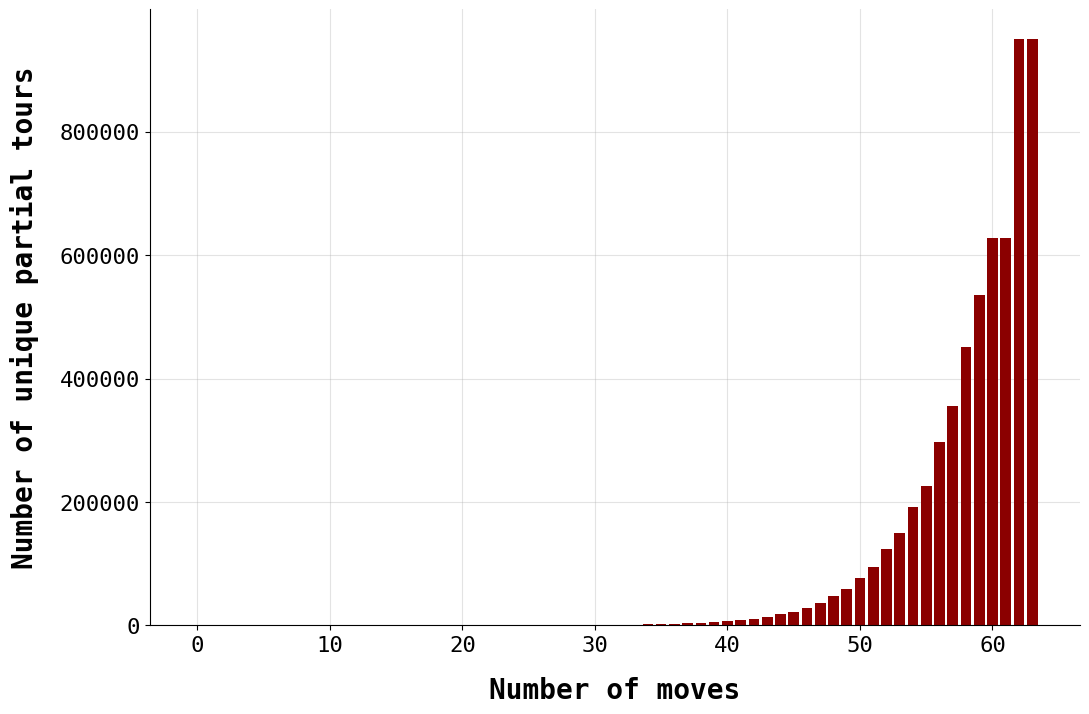

In [121]:
fig, ax= plt.subplots()

plt.bar(
    range(len(unique_tours_warnsdorff_df.row(0))), uniqueness_lengths_w, color="darkred"
)

plt.xlabel("Number of moves", fontweight='bold', labelpad = 15, fontsize = 20)
plt.ylabel("Number of unique partial tours", fontweight='bold', labelpad = 15, fontsize = 20)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.35)

plt.show()

### Creating another training and eval set

In [177]:
df_dictionaries = {
    f"df_0{i}": pl.read_parquet(f"../data/tours_8x8_1000000_20241201_recursive_0{i}.parquet") for i in range(4)
}

In [193]:
val_one_pos1 = df_dictionaries["df_01"].sample(fraction=0.033333, shuffle=True, seed=821378259)
val_one_pos2 = df_dictionaries["df_02"].sample(fraction=0.033333, shuffle=True, seed=821378259)
val_one_pos3 = df_dictionaries["df_03"].sample(fraction=0.033333, shuffle=True, seed=821378259)

val_one_pos = pl.concat([val_one_pos1, val_one_pos2, val_one_pos3]).sample(fraction=1, shuffle=True, seed=821378259)
val_one_pos

move_0,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,move_10,move_11,move_12,move_13,move_14,move_15,move_16,move_17,move_18,move_19,move_20,move_21,move_22,move_23,move_24,move_25,move_26,move_27,move_28,move_29,move_30,move_31,move_32,move_33,move_34,move_35,move_36,move_37,move_38,move_39,move_40,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50,move_51,move_52,move_53,move_54,move_55,move_56,move_57,move_58,move_59,move_60,move_61,move_62,move_63
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,19,4,14,20,35,29,44,27,21,36,26,16,33,43,49,59,53,63,46,31,37,52,58,48,42,32,17,0,10
3,9,24,41,56,50,60,54,39,22,7,13,23,6,12,2,8,18,1,16,33,48,58,52,62,47,30,15,5,11,28,45,55,38,21,31,37,27,10,25,40,57,51,61,44,34,49,43,26,36,19,4,14,20,35,29,46,63,53,59,42,32,17,0
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,19,4,14,29,44,27,33,16,10,0,17,32,42,48,58,52,46,63,53,59,49,43,26,36,21,31,37,20,35
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,44,27,33,48,58,43,37,20,26,16,10,0,17,32,49,59,42,36,53,63,46,52,35,29,14,31,21,4,19
3,9,24,41,56,50,60,54,39,22,7,13,23,6,12,2,8,18,1,16,33,48,58,52,62,47,30,15,5,11,28,45,55,38,21,31,37,27,44,29,35,20,14,4,10,0,17,32,26,43,49,34,51,61,46,63,53,36,19,25,40,57,42,59
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,8,25,40,57,51,61,55,38,23,6,12,22,7,13,3,9,24,41,56,50,60,54,39,45,62,47,30,15,5,11,1,18,28,34,44,59,53,63,46,36,21,31,14,4,19,29,35,20,37,52,42,48,58,43,26,16,33,27,10,0,17,32,49
1,16,33,48,58,52,62,47,30,15,5,11,17,0,10,4,14,31,21,6,23,13,7,22,39,54,37,20,3,9,24,41,56,50,60,43,26,32,42,59,49,34,19,2,8,18,12,27,44,29,46,63,53,36,51,57,40,25,35,45,28,38,55,61
3,9,24,41,56,50,60,54,39,22,7,13,23,6,12,2,8,18,1,16,33,48,58,52,62,47,30,15,5,11,28,45,55,38,21,4,10,0,17,27,37,31,14,20,35,29,44,61,51,36,46,63,53,59,49,34,19,25,40,57,42,32,26,43


In [194]:
val_one_pos = pl.DataFrame(val_one_pos.with_columns(pl.concat_list(val_one_pos.columns).alias("input_ids"))["input_ids"])
val_one_pos = val_one_pos.with_columns(pl.col("input_ids").alias("labels"))
val_one_pos

input_ids,labels
list[i8],list[i8]
"[2, 8, … 10]","[2, 8, … 10]"
"[3, 9, … 0]","[3, 9, … 0]"
"[2, 8, … 35]","[2, 8, … 35]"
"[2, 8, … 19]","[2, 8, … 19]"
"[3, 9, … 59]","[3, 9, … 59]"
…,…
"[2, 8, … 49]","[2, 8, … 49]"
"[1, 16, … 61]","[1, 16, … 61]"
"[3, 9, … 43]","[3, 9, … 43]"


In [195]:
val_one_pos.write_parquet(
    "../data/final/one_pos/validation_one_pos_8x8_99999.parquet",
    compression="zstd",
)

In [198]:
train_one_pos = df_dictionaries["df_00"].sample(fraction=1, shuffle=True, seed=821378259)
train_one_pos = pl.DataFrame(train_one_pos.with_columns(pl.concat_list(train_one_pos.columns).alias("input_ids"))["input_ids"])
train_one_pos = train_one_pos.with_columns(pl.col("input_ids").alias("labels"))
train_one_pos

input_ids,labels
list[i8],list[i8]
"[0, 17, … 35]","[0, 17, … 35]"
"[0, 17, … 46]","[0, 17, … 46]"
"[0, 17, … 44]","[0, 17, … 44]"
"[0, 17, … 33]","[0, 17, … 33]"
"[0, 17, … 14]","[0, 17, … 14]"
…,…
"[0, 17, … 33]","[0, 17, … 33]"
"[0, 17, … 53]","[0, 17, … 53]"
"[0, 17, … 19]","[0, 17, … 19]"


In [201]:
train_one_pos.write_parquet(
    "../data/final/one_pos/training_one_pos_8x8_1000000.parquet",
    compression="zstd",
)

In [200]:
train_one_pos

input_ids,labels
list[i8],list[i8]
"[0, 17, … 35]","[0, 17, … 35]"
"[0, 17, … 46]","[0, 17, … 46]"
"[0, 17, … 44]","[0, 17, … 44]"
"[0, 17, … 33]","[0, 17, … 33]"
"[0, 17, … 14]","[0, 17, … 14]"
…,…
"[0, 17, … 33]","[0, 17, … 33]"
"[0, 17, … 53]","[0, 17, … 53]"
"[0, 17, … 19]","[0, 17, … 19]"
